# Setup Test - VLM Pipeline

This notebook tests the core components:
- Data Loader (XML parsing)
- VLM Providers (Local, OpenAI, Google, Together AI)

In [1]:
import sys
import os
sys.path.append('..')

from src.data_loader import DataLoader
from src.providers import get_provider
from src.config import Config
import pandas as pd
from IPython.display import display, Markdown, Image
import json

## 1. Test Data Loader

### ✅ Successfully loaded 1856 annotations

### Sample Data:

,dataset,image_id,file_name,image_path,expert_score
0,NHTyp5,0,NHTyp5/ATT12295_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
1,NHTyp5,1,NHTyp5/ATT12318_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
2,NHTyp5,2,NHTyp5/ATT12341_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
3,NHTyp5,3,NHTyp5/ATT12361_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
4,NHTyp5,4,NHTyp5/ATT12541_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
5,NHTyp5,5,NHTyp5/ATT12707_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
6,NHTyp5,6,NHTyp5/ATT12730_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
7,NHTyp5,7,NHTyp5/ATT12762_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
8,NHTyp5,8,NHTyp5/ATT13036_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN
9,NHTyp5,9,NHTyp5/ATT13041_PropertyConditionAssessment_im...,/home/exouser/DSM-property-condition-assessmen...,NaN


### Sample Image Path: `/home/exouser/DSM-property-condition-assessment/Data/extractedimages/NHTyp5/ATT12295_PropertyConditionAssessment_image-20220831-135723.jpg`

### ✅ Image file exists

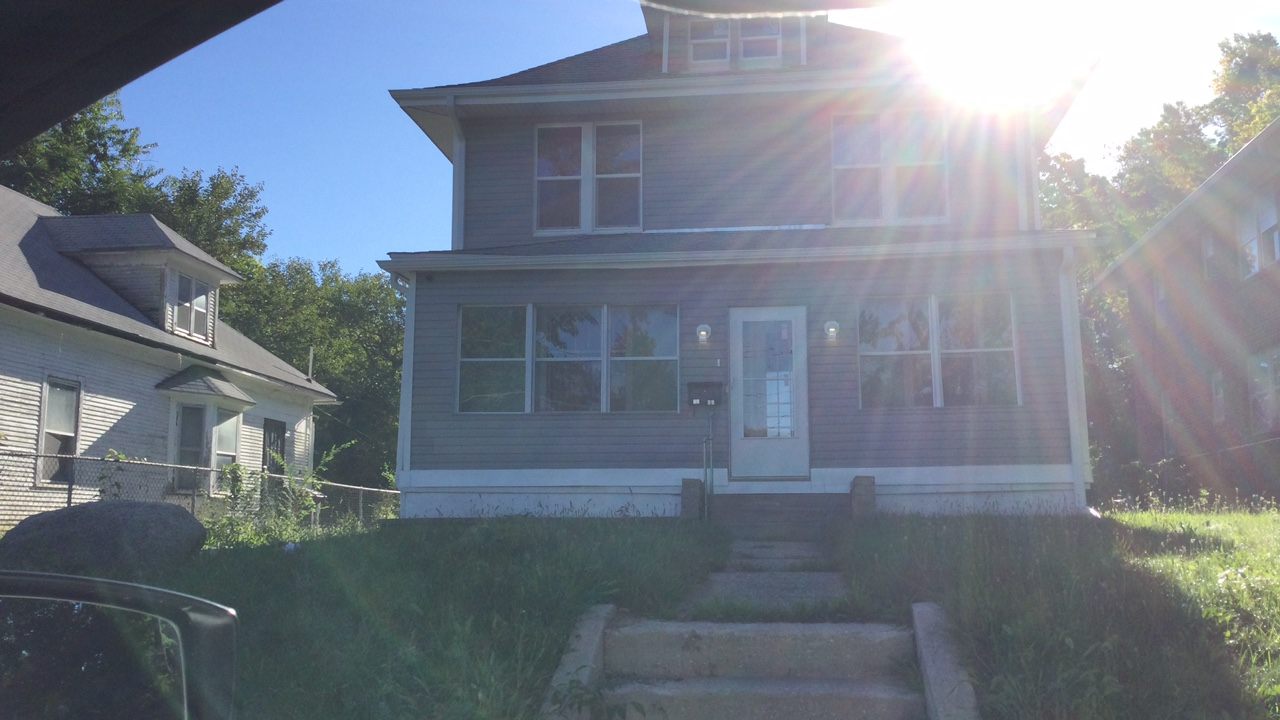

In [2]:
loader = DataLoader()
df = loader.load_annotations()

display(Markdown(f'### ✅ Successfully loaded {len(df)} annotations'))

display(Markdown('### Sample Data:'))
display(df.head(10))

if not df.empty:
    sample_image_path = df.iloc[0]['image_path']
    display(Markdown(f'### Sample Image Path: `{sample_image_path}`'))
    
    if os.path.exists(sample_image_path):
        display(Markdown('### ✅ Image file exists'))
        display(Image(sample_image_path, width=400))
    else:
        display(Markdown('### ⚠️ Image not found'))
        alt_path = os.path.join('..', 'Data', 'extractedimages', df.iloc[0]['file_name'])
        if os.path.exists(alt_path):
            display(Markdown(f'Found at: `{alt_path}`'))
            display(Image(alt_path, width=400))
            sample_image_path = alt_path
else:
    sample_image_path = None

## 2. Test Local Provider (Ollama)

In [3]:
if sample_image_path and os.path.exists(sample_image_path):
    display(Markdown('### Testing Local Provider (Ollama)'))
    
    provider = get_provider('local')
    prompt = '''Analyze this property image and return a JSON object with:
    {
        "is_clear": boolean,
        "house_visible": boolean,
        "description": string
    }'''
    
    display(Markdown(f'**Model:** {provider.model_name}'))
    display(Markdown(f'**API URL:** {provider.api_url}'))
    
    try:
        response = provider.analyze(sample_image_path, prompt)
        if response:
            display(Markdown('### ✅ Response Received:'))
            try:
                clean_response = response.strip()
                if '```json' in clean_response:
                    clean_response = clean_response.split('```json')[1].split('```')[0].strip()
                elif '```' in clean_response:
                    clean_response = clean_response.split('```')[1].split('```')[0].strip()
                parsed = json.loads(clean_response)
                display(Markdown('**Formatted JSON:**'))
                display(json.dumps(parsed, indent=2))
            except:
                display(Markdown('**Raw Response:**'))
                display(Markdown(f'```\n{response}\n```'))
        else:
            display(Markdown('### ❌ Empty response - Check if Ollama is running'))
    except Exception as e:
        display(Markdown(f'### ❌ Error: {str(e)}'))
else:
    display(Markdown('### ⚠️ Skipping: No valid image found'))

### Testing Local Provider (Ollama)

**Model:** gemma3:27b

**API URL:** http://localhost:11434/api/generate

### ✅ Response Received:

**Formatted JSON:**

'{\n  "is_clear": true,\n  "house_visible": true,\n  "description": "The image shows a two-story, light-gray house with a front porch and a slightly overgrown lawn. There is another house visible to the side. The image is taken during daylight hours, with bright sunlight causing some glare."\n}'

## 3. Test OpenAI Provider

In [4]:
if sample_image_path and os.path.exists(sample_image_path) and Config.OPENAI_API_KEY:
    display(Markdown('### Testing OpenAI Provider'))
    provider = get_provider('openai')
    prompt = 'Describe this property image briefly.'
    display(Markdown(f'**Model:** {provider.model_name}'))
    try:
        response = provider.analyze(sample_image_path, prompt)
        if response:
            display(Markdown('### ✅ Response:'))
            display(Markdown(response))
        else:
            display(Markdown('### ❌ Empty response'))
    except Exception as e:
        display(Markdown(f'### ❌ Error: {str(e)}'))
else:
    if not Config.OPENAI_API_KEY:
        display(Markdown('### ⚠️ Skipping: OPENAI_API_KEY not set'))
    else:
        display(Markdown('### ⚠️ Skipping: No valid image found'))

### Testing OpenAI Provider

**Model:** gpt-4o

### ✅ Response:

The image shows a two-story house with gray siding. The front features a row of large windows and a central door, with steps leading up to the entrance. The property is set on a grassy lawn with a path. Sunlight is streaming over the house from the top right corner, creating a lens flare effect. Adjacent to the left, another house is partially visible.

## 4. Test Google Provider

In [5]:
if sample_image_path and os.path.exists(sample_image_path) and Config.GOOGLE_API_KEY:
    display(Markdown('### Testing Google Provider'))
    provider = get_provider('google')
    prompt = 'Describe this property image briefly.'
    display(Markdown(f'**Model:** {provider.model_name}'))
    try:
        response = provider.analyze(sample_image_path, prompt)
        if response:
            display(Markdown('### ✅ Response:'))
            display(Markdown(response))
        else:
            display(Markdown('### ❌ Empty response'))
    except Exception as e:
        display(Markdown(f'### ❌ Error: {str(e)}'))
else:
    if not Config.GOOGLE_API_KEY:
        display(Markdown('### ⚠️ Skipping: GOOGLE_API_KEY not set'))
    else:
        display(Markdown('### ⚠️ Skipping: No valid image found'))

### Testing Google Provider

**Model:** gemini-3-pro-preview

### ✅ Response:

Based on the image, here is a brief description of the property:

**Exterior Structure**
The image shows a two-story, single-family home featuring light gray horizontal siding and a dark shingled hip roof with a central dormer window at the top.

**Features**
*   **Entrance:** There is a central white front door with a glass pane, flanked by small exterior light fixtures.
*   **Windows:** The ground floor has large sets of windows on either side of the door, while the second story features paired double-hung windows aligned above them.
*   **Landscaping:** The house sits on an elevated lot with a set of aging concrete stairs leading up from the street level. The front lawn consists of tall, somewhat overgrown grass.

**Surroundings & Conditions**
*   **Lighting:** The photo is taken on a sunny day, with intense sunlight streaming from the upper right, creating a significant lens flare that obscures part of the house.
*   **Neighborhood:** A white, smaller neighboring house with a chain-link fence is visible to the left, and trees fill the background.
*   **Perspective:** The photo appears to have been taken from inside a vehicle, as parts of a car door or mirror are visible in the bottom left corner.

## 5. Test Together AI Provider

In [6]:
if sample_image_path and os.path.exists(sample_image_path) and Config.TOGETHER_API_KEY:
    display(Markdown('### Testing Together AI Provider'))
    provider = get_provider('together')
    prompt = 'Describe this property image briefly.'
    display(Markdown(f'**Model:** {provider.model_name}'))
    try:
        response = provider.analyze(sample_image_path, prompt)
        if response:
            display(Markdown('### ✅ Response:'))
            display(Markdown(response))
        else:
            display(Markdown('### ❌ Empty response'))
    except Exception as e:
        display(Markdown(f'### ❌ Error: {str(e)}'))
else:
    if not Config.TOGETHER_API_KEY:
        display(Markdown('### ⚠️ Skipping: TOGETHER_API_KEY not set'))
    else:
        display(Markdown('### ⚠️ Skipping: No valid image found'))

### Testing Together AI Provider

**Model:** Qwen/Qwen2.5-VL-72B-Instruct

### ✅ Response:

This property image shows a two-story house with a gray exterior and white trim. The house features a prominent front porch with steps leading up to it. The windows are large and evenly spaced, with a dormer window on the second floor. The sun is shining brightly, creating lens flares in the image. The surrounding area includes a lawn with some overgrown grass, and neighboring houses are visible on either side. The sky is clear and blue, indicating a sunny day.

## Summary

All core components have been tested. Check the results above.